In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 53.6MB/s 
     |████████████████████████████████| 194kB 57.1MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 


In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [8]:
dblock = DataBlock(get_x = lambda x: x['fname'], get_y = lambda x: x['labels'])

In [9]:
dsets = dblock.datasets(df)

In [10]:
dsets.train[0]

('005620.jpg', 'aeroplane')

In [11]:
def get_x(x): return x['fname']
def get_y(x): return x['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

('005378.jpg', 'chair')

In [12]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

(Path('/root/.fastai/data/pascal_2007/train/009596.jpg'),
 ['motorbike', 'person', 'car'])

In [13]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(blocks = [ImageBlock, MultiCategoryBlock], get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[1]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]))

In [14]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [15]:
def my_splitter(df):
    train = df.index[~df.is_valid].to_list()
    valid = df.index[df.is_valid].to_list()
    return train, valid

In [16]:
def get_x(x): return path/'train'/x['fname']
def get_y(x): return x['labels'].split(' ') # This is the standard split from https://docs.python.org/3/library/stdtypes.html#str.split and does not accept regexes
dblock = DataBlock(blocks = [ImageBlock, MultiCategoryBlock], get_x = get_x, get_y = get_y, splitter=my_splitter, item_tfms=[RandomResizedCrop(128, min_scale = 0.35)])
dsets = dblock.datasets(df)
dsets.train[1]
dls = dblock.dataloaders(df)

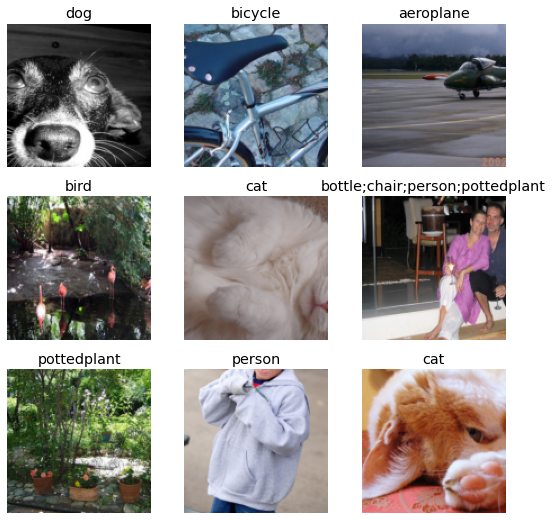

In [17]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [19]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [20]:
activs[0].sigmoid()

tensor([0.6787, 0.2317, 0.9895, 0.1692, 0.3374, 0.5086, 0.0764, 0.3030, 0.4057, 0.1843, 0.4580, 0.8961, 0.0318, 0.2361, 0.5382, 0.1571, 0.0906, 0.6696, 0.2082, 0.4082], grad_fn=<SigmoidBackward>)

In [21]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets == 1., 1-inputs, inputs).log().mean()

# The prediction that we have is a number from 0 to 1 (after the sigmoid)
# If the target is 1 we want our prediction to be close to 1 and the opposite if the target is 0
# After the where part, we have some losses which are all below 1 and we take the log which results in a negative loss
# Afterwards we take the mean of those losses and finally we multiply by -1 in order to convert the number back to a positive

In [22]:
binary_cross_entropy(activs, y)

TensorMultiCategory(1.0954, grad_fn=<AliasBackward>)

In [23]:
loss_func = nn.BCEWithLogitsLoss()
loss_func(activs, y)

TensorMultiCategory(1.0342, grad_fn=<AliasBackward>)

In [24]:
# Defining multi label accuracy
def multi_label_accuracy(preds, targets, thresh = 0.2, sigmoid = True):
    if sigmoid: preds = preds.sigmoid()
    return ((preds >= thresh) == (targets.bool())).float().mean()

In [25]:
learn = cnn_learner(dls, resnet50, metrics=partial(multi_label_accuracy, thresh = 0.5))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [26]:
learn.fine_tune(3, base_lr = 3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.943426,0.692181,0.628128,00:30
1,0.823293,0.563051,0.733606,00:30
2,0.604115,0.199898,0.949562,00:30
3,0.359253,0.123859,0.957829,00:30


epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.131439,0.116159,0.959721,00:31
1,0.115950,0.107240,0.962510,00:31
2,0.096154,0.104989,0.962968,00:31


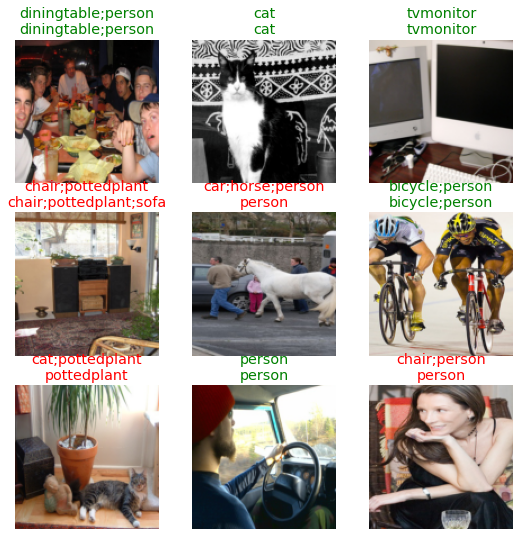

In [28]:
learn.show_results()

In [29]:
preds, targs = learn.get_preds()

In [34]:
accuracy_multi(preds, targs, sigmoid = False)

TensorBase(0.9630)

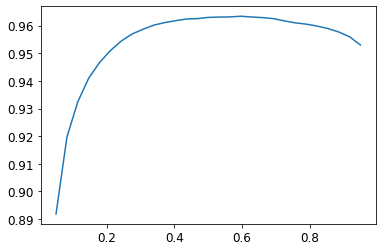

In [35]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [38]:
opt_threshold_lvl = xs[np.argmax(accs)]
opt_threshold_lvl

tensor(0.5964)

#Part 2 - Face center recognition

In [60]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/05.obj'),Path('/root/.fastai/data/biwi_head_pose/17'),Path('/root/.fastai/data/biwi_head_pose/19.obj'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/10.obj')...]

In [40]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00046_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00043_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00109_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00437_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00255_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00406_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00171_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00361_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00340_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00015_rgb.jpg')...]

In [61]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/13/frame_00046_pose.txt')

(480, 640)


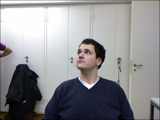

In [50]:
im = PILImage.create(img_files[0])
print(im.shape)
im.to_thumb(160)

In [52]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0]*cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1]*cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [53]:
get_ctr(img_files[0])

tensor([344.6212, 224.5428])

In [62]:
biwi = DataBlock(
      blocks = (ImageBlock, PointBlock),
      get_items=get_image_files,
      get_y = get_ctr,
      splitter = FuncSplitter(lambda o: o.parent.name == '13'),
      batch_tfms = [*aug_transforms(size=(240, 320)),
                    Normalize.from_stats(*imagenet_stats)]
)
dls = biwi.dataloaders(path)

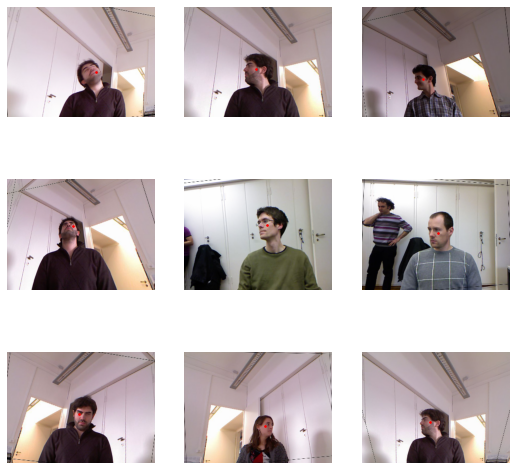

In [63]:
dls.show_batch()

In [64]:
learn = cnn_learner(dls, resnet18, y_range = (-1,1))

In [65]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.0964781722577754e-06)

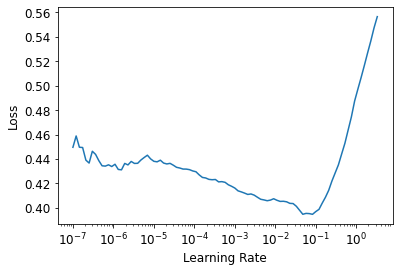

In [66]:
learn.lr_find()

In [67]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.046482,0.022428,02:10
1,0.006683,0.002474,02:10
2,0.002976,0.000772,02:10
3,0.002003,0.000297,02:10
4,0.001673,0.000749,02:10
